In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2

In [ ]:
def download_dataset():
  # set up kaggle api and credentials
  ! pip install -q kaggle
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  # download the dataset
  !kaggle datasets download -d 'tanlikesmath/diabetic-retinopathy-resized'
  #unzip
  !mkdir diabetic-retinopathy-resized
  !unzip diabetic-retinopathy-resized.zip -d diabetic-retinopathy-resized
  !mv ./* diabetic-retinopathy-resized

In [ ]:
import os
dataset_dir_exist = os.path.isdir('diabetic-retinopathy-resized')
if not dataset_dir_exist:
  print('downloading dataset')
  download_dataset()


downloading dataset


Streaming output truncated to the last 5000 lines.
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44261_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44261_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44262_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44262_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44263_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44263_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44264_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44264_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44265_left.jpeg  
  inflati

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
pd.read_csv("./diabetic-retinopathy-resized/trainLabels.csv")['level'].unique()

# classes

array([0, 1, 2, 4, 3])

In [ ]:
cropped = pd.read_csv("./diabetic-retinopathy-resized/trainLabels_cropped.csv")[:5000]

In [ ]:
cropped.iloc[0]

Unnamed: 0            0
Unnamed: 0.1          0
image           10_left
level                 0
Name: 0, dtype: object

In [ ]:
image_names = os.listdir("./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/")
image_names.sort()
image_names[:5]

['10003_left.jpeg',
 '10003_right.jpeg',
 '10007_left.jpeg',
 '10007_right.jpeg',
 '10009_left.jpeg']

In [ ]:
images_path = "./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped"
img_path = os.path.join(images_path, cropped.iloc[3500].image+".jpeg")
img_path

'./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/4380_left.jpeg'

(1024, 1024)

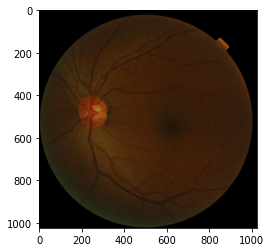

In [ ]:
img = Image.open(img_path)

plt.imshow(img)

img.size

In [ ]:
class convert_to_grey(object):
    def __call__(self, img):
        """
        :param img: PIL): Image 

        :return: greyscale image with weight
        """
        image = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (image.shape[0], image.shape[0]))
        image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , image.shape[0]/10) ,-4 ,128) # the trick is to add this line
        # work around: need to copy values for the third dimension, so that it can use InceptionV3 pretrain model
        return np.repeat(image[..., np.newaxis], 3, -1)
       

In [ ]:
import torchvision.transforms as transforms
train_transform = transforms.Compose([
    #transforms.Resize((299,299)),
    transforms.Resize((800,800)),
    # augmentation
    #convert_to_grey(),
    transforms.ToTensor(),

    # below doesn't perform well
    # transforms.RandomResizedCrop((299,299)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    #transforms.Resize((299,299)),
    transforms.Resize((800,800)),

    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])


In [ ]:
!ls ./diabetic-retinopathy-resized/

diabetic-retinopathy-resized.zip  resized_train_cropped    trainLabels.csv
kaggle.json			  sample_data
resized_train			  trainLabels_cropped.csv


In [ ]:
import torch

class retinaDataset(Dataset):
    def __init__(self, transform, imagepath="./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped", total=None):
        self.df = pd.read_csv("./diabetic-retinopathy-resized/trainLabels_cropped.csv")
        
        if (total is not None):
            self.df = self.df[:total]
        
        self.transform = transform
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        img = Image.open(img_path)
        
        if(self.transform):
            img = self.transform(img)
        
        return img, torch.tensor(self.df.iloc[index].level)


In [ ]:
# Load images. The two dataset is the same except for the transformation applied
full_dataset = retinaDataset(transform=train_transform, total=None)
valid_and_test_dataset = retinaDataset(test_transform, total=None)

(torch.Size([3, 800, 800]), tensor(0), 35108)

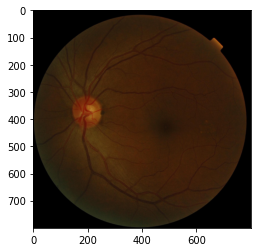

In [ ]:
img, label = full_dataset[3500]
plt.imshow(img.permute(1,2,0))
img.shape, label, full_dataset.__len__()

In [ ]:
num_classes = 5
learning_rate = 1e-4
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torchvision.models import inception_v3

model = inception_v3(pretrained=True)

# whether to use the auxillary output
use_aux = True

# fine tuning entire model
for param in model.parameters():
    param.requires_grad = False
    
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
model.fc = torch.nn.Linear(in_features=2048, out_features=5, bias=True)

# linear layer aux output
if use_aux:
  num_ftrs = model.AuxLogits.fc.in_features
  model.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
else:
  model.aux_logits = False

model = model.to(device=device)
#model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

In [ ]:
batch_size = 32

In [ ]:
# train:validation:test: 7:2:1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(full_dataset)
indices = list(range(dataset_size))

train_split, val_split = 0.7, 0.9
train_split_point_idx = int(np.floor(train_split * dataset_size))
val_split_point_idx = int(np.floor(val_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:train_split_point_idx], \
                                           indices[train_split_point_idx:val_split_point_idx], \
                                           indices[val_split_point_idx:]
print(len(train_indices), len(val_indices), len(test_indices))
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = DataLoader(dataset=full_dataset, batch_size=batch_size, sampler=train_sampler)
validation_dataloader = DataLoader(dataset=valid_and_test_dataset, batch_size=batch_size, sampler=valid_sampler)
test_dataloader = DataLoader(dataset=valid_and_test_dataset, batch_size=batch_size, sampler=test_sampler)

dataloaders = {'train': train_dataloader, 'val': validation_dataloader, 'test': test_sampler}

24575 7022 3511


In [ ]:
from tqdm import tqdm
losses_train = []
accs_train = []
losses_val = []
accs_val = []

for epoch in range(num_epochs):
    # training and validation phases for each epoch
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0
        # iterate over batches
        for data, target in tqdm(dataloaders[phase]):
            data = data.to(device=device)
            target = target.to(device=device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                if use_aux and phase == 'train':
                    score, aux_outputs = model(data)
                    loss1 = loss_criterion(score, target)
                    loss2 = loss_criterion(aux_outputs, target)
                    loss = loss1 + 0.4*loss2
                else:
                    score = model(data)
                    loss = loss_criterion(score, target)

                # get predicted classes
                _, preds = torch.max(score, 1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # record loss
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == target.data)

        epoch_loss = running_loss / (len(dataloaders[phase]) * batch_size)
        epoch_acc = 100 * running_corrects.double() / (len(dataloaders[phase]) * batch_size)
        print(f"for epoch {epoch}, {phase} loss : {epoch_loss}, {phase} accuracy: {epoch_acc}")
        if phase == 'train':
            losses_train.append(epoch_loss)
            accs_train.append(epoch_acc)
            # save the model every 5 epochs
            if epoch % 5 == 0:
              print("saving model")
              save_model("/content/gdrive/My Drive/543_final_project_files/higher_res")
        else:
            losses_val.append(epoch_loss)
            accs_val.append(epoch_acc)
     
# loss curve
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='validation')
plt.legend()
plt.show()

# accuracy curve
plt.plot(accs_train, label='train')
plt.plot(accs_val, label='validation')
plt.legend()
plt.show()

    

100%|██████████| 768/768 [20:00<00:00,  1.56s/it]


for epoch 0, train loss : 1.2367342589374555, train accuracy: 73.4130859375
saving model


 37%|███▋      | 82/220 [02:09<03:41,  1.61s/it]

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    
    correct_output = 0
    total_output = 0
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            score = model(x)
            _,predictions = score.max(1)
            
            correct_output += (y==predictions).sum()
            total_output += predictions.shape[0]
    model.train()
    print(f"out of {total_output} , total correct: {correct_output} with an accuracy of {float(correct_output/total_output)*100}")

In [ ]:
# get accuracy on test set
evaluate_model(model, test_dataloader)


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

out of 10 , total correct: 9 with an accuracy of 90.00000357627869


In [ ]:
# polot ROC curve
y_true, y_pred, y_pred_prob = pytorch_predict(model, test_dataloader, device)
print(len(y_true))

#plotROC(y_pred, y_true)

IndexError: ignored

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


# plot ROC curve 

def plotROC(y_pred, y_test): 
    # Plotting ROC curve
    y = y_test
    # Binarize the output
    y = label_binarize(y, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC for specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to specific class')
    plt.legend(loc="lower right")
    plt.show()
    
    print(' ')
    
    # Plot ROC curve for multi class
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
import torch.nn.functional as F

def pytorch_predict(model, test_loader, device):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)
    
    # deactivate autograd engine and reduce memory usage and speed up computations
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)
    
    y_true = y_true.cpu().numpy()  
    _, y_pred = torch.max(all_outputs, 1)
    y_pred = y_pred.cpu().numpy()
    y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
    
    return y_true, y_pred, y_pred_prob

In [ ]:
image = Image.open("../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/10007_right.jpeg")

img = my_transform(image).unsqueeze(0)

score = model(img)

_, predictions = score.max(1)

plt.imshow(image)

print("predicted: ", predictions)

df = pd.read_csv("../input/diabetic-retinopathy-resized/trainLabels_cropped.csv")

# print(df[image][:5])
# print(df.loc[df[image]=="10_left"].level)
print("actual: ", df.loc[df['image'].isin(['10007_right'])].level)


In [ ]:
# change current working directory for output
def save_model(output_dir):
  os.chdir(output_dir)
  import time
  timestr = time.strftime("%Y%m%d-%H%M%S")

  model_output_path = f"model-epoch-{epoch}-" + timestr + ".pth"
  torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, model_output_path)
  
  # save data loaders for resuming training

  torch.save(train_dataloader, f'train-dataloader-{timestr}.pth')
  torch.save(validation_dataloader, f'val-dataloader-{timestr}.pth')
  torch.save(test_dataloader, f'test-dataloader-{timestr}.pth')

  # change the wd back
  os.chdir("/content/")

In [ ]:
  os.chdir("/content/")

In [ ]:
# loading model
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()